# Final project -- Numerical Analysis -- 2020/2021

## General goal

Consider the hyper-cube $\Omega := [-1,1]^d$ in dimension `d`.

Given a function $f: \Omega \mapsto R$, find $u: \Omega \mapsto R$ such that 

$ \Delta u  + u = f, \text{ in } \Omega$

$
\frac{\partial u}{\partial n} = 0 \text{ on } \partial \Omega
$

using Chebyshev spectral elements, and in a matrix-free framework.

## Due date: 

- MHPC students: 20 February 2021
- DSSC/LM/PHD students: 1 day before the oral examination

## General definitions

We recall here some general definitions that will be useful throughout the project.

- The space $Q^p(\Omega)$ is the space of polynomials of order $p$ in each coordinate direction. The dimension of $Q^p$ is $(p+1)^d$ where $d$ is the dimension of the space. 

- A tensor product basis for $Q^p(\Omega)$ can be constructed from a basis for $P^p([-1,1])$, by arranging the indices in d-dimensional arrays, i.e., if $\{v_i\}_{i=0}^p$ is a basis for $P^p([-1,1])$, then, for example, 
$
v_{ijk} := v_i(x_0)v_j(x_1)v_k(x_2)
$
is a basis for $Q^p([-1,1]^3)$.

- Chebyshev points of type 2 are Chebishev points in one dimension that include end points. These are not minimizers of the linfty norm of the Lebesgue function (those are Chebishev points of type 1), but are minimizers of Lebesgue function when you constrain two of the points to coincide with the extremes of the interval $[-1,1]$. You can obtain those points by calling `numpy.polynomial.chebyshev.chebpts2`.

- Chebyshev spectral elements are the tensor product basis for $Q^p(\Omega)$, generated by the Lagrange basis functions constructed using as support points the Chebyshev points of type 2. In one dimension, for degree=5, npoints=6, they look like:

![picture](1.png)

- Integration in each coordinate direction can be performed using Gauss quadrature formulas, which can be queried by the function `numpy.polynomial.legendre.leggauss`. That function returns a tuple of two objects,  containing both the quadrature points `q` and the quadrature weights `w`, i.e., `q, w = numpy.polynomial.legendre.leggauss(nq)`.

- The construction of a Lagrange basis can be done easily by calling `scipy.interpolate.lagrange(X, ei)` where `X` are the interpolation points, and `ei` is a vector containing all zeros, except a one in the position corresponding to the index i. For example, the following code 

~~~
X = numpy.polynomial.chebyshev.chebpts2(6)
e_3 = zeros((6,))
e_3[3] = 1

B_3 = lagrange(X, e_3)
B_3_prime = polyder(B_3)

x = linspace(-1,1,501)
plot(x, B_3(x))
plot(X, 0*X, 'ro')
figure()
plot(x, B_3_prime(x))
plot(X, 0*X, 'ro')
~~~

will produce the following pictures

![picture](2.png)

![picture](3.png)

Which correspond to the fourth (`index=3`) Chebishev spectral basis function and its derivative, for the space $P^5([-1,1])$.

The functions `B_3` and `B_3_prime` computed above are callable functions, i.e., you can evaluate the basis and its derivative as normal functions, and they accept as input numpy arrays.

## Weak formulation

The weak form of the problem reads:

Given $f:\Omega \mapsto R$, find $u\in H^1(\Omega)$ such that

$
\int_\Omega \nabla u \cdot \nabla v + \int_\Omega u v = \int_\Omega f v \qquad \forall v \in H^1(\Omega)
$

## Discrete weak formulation (one dimensional case)

Given a finite dimensional space $V_h \subset H^1([-1,1])$ such that  $V_h = \text{span}\{v_i\}_{i=0}^p$, then
the discrete problem reads:

Find $u$ such that

$
A u = f 
$

where $A$ is a matrix in  $R^{(p+1)\times(p+1)}$  and $f$ is a vector in $R^{(p+1)}$ 

$
A_{ij} = \int_\Omega \nabla v_j \cdot \nabla v_i+\int_\Omega  v_j  v_i, \qquad f_i = \int_\Omega f v_i
$

that is (using a quadrature with $q_\alpha$ and $w_\alpha$ as points and weights):

$
A_{ij} = \sum_{\alpha=0}^{nq-1}\left( v'_j(q_\alpha) v'_i(q_\alpha)+  v_j(q_\alpha)  v_i(q_\alpha)\right)w_\alpha
$

$
f_{i} = \sum_{\alpha=0}^{nq-1} v_j(q_\alpha) f(q_\alpha) w_\alpha
$

Let's assume we have computed the matrices $B_{i\alpha} := v_i(q_\alpha)$, and $D_{i\alpha} := v'_i(q_\alpha)$ containing the evaluation of all basis functions and of their derivatives in the quadrature points $q_\alpha$.  

The matrix $A$ can then be written as

$
A_{ij} = \sum_\alpha \left(D_{i\alpha} D_{j\alpha} w_\alpha + B_{i\alpha} B_{j\alpha} w_\alpha\right) = K_{ij} + M_{ij}
$

where $K$ is usually known as the one dimensional stiffness matrix, and $M$ as the one dimensional mass matrix:


$
K_{ij} = \sum_\alpha \left(D_{i\alpha} D_{j\alpha} w_\alpha \right)
$


$
M_{ij} = \sum_\alpha \left(B_{i\alpha} B_{j\alpha} w_\alpha \right)
$

Using numpy and Lapack, these can be computed efficiently by calling `einsum`:

~~~
K = einsum('iq, q, jq', D, w, D)
M = einsum('iq, q, jq', B, w, B)
~~~

where the function `einsum` interprets the first argument (a string) as a list of indices over which sum should occur. The list must be of the same length of the other arguments (3 in this case), and the number of indices for each entry musth match the input (i.e., `iq` for `D`, and `q` for `w`). The three arrays are multiplied entry by entry, and if an index is repeated in the description, those entries are summed over (see the documentation).

## Higher dimensional case

If we have already computed the one dimensional matrices $B_{i\alpha} = v_i(q_\alpha)$ and $D_{i\alpha} := v'_i(q_\alpha)$ we can compute easily the 2 and 3 dimensional versions of the stiffness, mass, and system matrices.

In particular, defining $q_{\alpha\beta} := (q_\alpha, q_\beta)$, and $w_{\alpha\beta} = w_\alpha w_\beta$, we have

$\nabla v_{ij}(q_{\alpha\beta}) \cdot \nabla v_{kl}(q_{\alpha\beta}) := v'_i(q_{\alpha})v_j(q_{\beta})v'_k(q_{\alpha})v_l(q_{\beta}) + v_i(q_{\alpha})v'_j(q_{\beta})v_k(q_{\alpha})v'_l(q_{\beta})$. 

Integrating with quadrature twice (once for each dimension), we get:

$
K_{ij,kl} := \sum_q \sum_p v'_i(X_q)v_j(X_p)v'_k(X_q)v_l(X_p) + v_i(X_q)v'_j(X_p)v_k(X_q)v'_l(X_p) w_p w_q
$

These are easily expressed directly through python `einsum`, i.e., 

```
KM = einsum('iq, jp, q, p, kq, lp -> ijkl', D, B, w, w, D, B)
MK = einsum('iq, jp, q, p, kq, lp -> ijkl', D, B, w, w, B, D)
KK = KM+MK
```

Or, if we have already the one dimensional matrices $K_{ij}$ and $M_{ij}$, then the above become:

$
A_{ij,kl} := K_{ik}M_{jl} + M_{ik}K_{jl} + M_{ik}M_{jl}
$

which, using the `einsum` command, becomes:

```
KM = einsum('ik, jl -> ijkl', K, M)
MK = einsum('ik, jl -> ijkl', M, K)
MM = einsum('ik, jl -> ijkl', M, M)
KK = KM+MK
AA = KK+MM

```

The resulting array can be reshaped to a two dimensional matrix by calling `AA.reshape((n**2, n**2))`, and solved for using `linalg.solve`.

Similarly in 3 dimensions:


$
A_{ijk,lmn} := (K_{il}M_{jm}M_{kn}+M_{il}K_{jm}M_{kn}+M_{il}M_{jm}K_{kn})+M_{il}M_{jm}M_{kn}
$

Sums of the kind $D_{ijk,lmn} = A_{il}B_{jm}C_{kn}$ can be expressed using `einsum` as

```
D = einsum('il, jm, kn -> ijklmn', A, B, C)
```

And the resulting six-dimensional array can be reshaped to a matrix by calling `D.reshape((n**3, n**3))`.

## Intermediate assignments

### 1. One dimensional matrices
Write a function that, given the number of Chebishev points `n`, returns `K`, `M`, and `A` for a one dimensional problem, integrated exactly using Gauss quadrature formulas with the correct number of quadrature points 

In [1]:
import numpy as np
import math
import scipy.interpolate as spi
import sympy as sym
import matplotlib.pyplot as plt


In [2]:
def lagrangian_basis_generator(x):
  '''Input: 
      x: input nodes on which to generate the lagrangian basis.

     Output:
      v_i: generator of lagrangian basis v_i(x_j) = delta_i_j
  ''' 
  n = len(x)
  tmp = np.zeros(n)
  for i in range(n):
    tmp[i-1] = 0
    tmp[i] = 1
    v_i = spi.lagrange(x,tmp)
    yield v_i


def compute_one_dimensional_matrices(n):
    '''Input:
        n: number of points in interval [-1, 1].
       Output: 
        (K, M, A)
       K: Stiffness matrix
       M: Mass matrix
       A: FEM matrix where A_ij = K_ij + M_ij 
    '''
    
    # CONSTRUCTION OF LAGRANGIAN BASIS
    # generate chebyshev points of type 2
    X_cheb = np.polynomial.chebyshev.chebpts2(n)

    # generate the quadradure points
    # number of quadrature points
    nq = n
    q, w = np.polynomial.legendre.leggauss(nq)

    #Allocate space for B and D
    B = np.zeros((n,nq))
    D = np.zeros((n,nq))

    for i, v_i in enumerate(lagrangian_basis_generator(X_cheb)): 
      #compute the derivative of v_i
      v_prime_i = np.polyder(v_i)

      #fill matrices B and D
      B[i, :] = v_i(q)
      D[i, :] = v_prime_i(q)

        
    K = np.einsum('iq, q, jq', D, w, D)
    M = np.einsum('iq, q, jq', B, w, B)
    A = K + M
    
    return K, M, A


To choose the number of quadrature point, we must remember that $I^d(f)$ has accuracy of $(2d+1)$ where $d$ is the degree of the interpolating polynomial of $f$ and the number of quadrature points $n_q = d + 1$. 
Given $n$ Chebyshev points, we want to integrate a polynomial of power $2n-2$. Thus, to utilize the least number of quadrature points, we require $2d+1 = 2n-2$, which means $2n_q - 1 = 2n-2$. 

So in the end we obtain $n_q = n - \frac{1}{2} \approx n$

### 2. Error in one dimension

Using 

$
u_{exact}(x) = \cos(\pi x)
$

as the exact solution, compute the forcing term $f$ that should go on the right hand side of the system to ensure that the exact solution is $u$, i.e., $f = -\Delta u + u$  

Use $f$ to compute the right hand side of your problem, and solve the problem (using `linalg.solve`) for increasing numbers of Chebishev points. Compute the $L^2$ error between the exact solution and the computed approximatio, using a higher order quadrature w.r.t. what you used to assemble the matrices. 

Plot the error as a function of $n$, for $n$ in $[10,...,20]$.

In [8]:
def u_symbolic(dims):
  '''returns u_exact in symbolic form in d-dimensions
     input:
      dims: dimensions of the problem
  '''
  vars = sym.symbols('x:%d'%dims)
  u_ex = 1
  for i in range(dims):
    u_ex*=sym.cos(sym.pi*vars[i])
  return u_ex

def u_exact(*args):
  '''lambdifies u_symbolic(dims) to numpy
     and then applies it to the input np.array(s).
     Mainly used for error plotting purposes and to calculate the error!
     input:
      x: np.array of input points where function is
         calculated.
     output:
      u(x) as np.array
  '''
  assert len(args)>=1

  dims = len(args)
  u_sym = u_symbolic(dims)
  vars = list(u_sym.free_symbols)
  u = sym.lambdify(vars, u_sym, 'numpy')
  return u(*args)
  
def f(*args):
  '''return np.array of rhs where f(x) = -delta u(x) + u(x)''' 
  #second derivative of u_exact
  dims = len(args)
  u_sym = u_symbolic(dims)
  vars = list(u_sym.free_symbols)
  u = sym.lambdify(vars, u_sym, 'numpy')
  u_delta = 0*vars[0]
  for i in range(dims):
    u_delta += sym.diff(u_sym, vars[i], 2)
  u_delta_lambdify = sym.lambdify(vars, u_delta, 'numpy')
  return  -1*u_delta_lambdify(*args) + u(*args)

def rhs_one_d(x):
  '''input:
      x: chebyshev points.
     output:
      rhs: np.array of the right hand side.
  '''
  n = len(x)
  #Generate quadrature points
  # nq is the size of the quadrature points
  nq = n
  q, w = np.polynomial.legendre.leggauss(nq)

  rhs = np.empty(n)
  #Generate the basis
  for i, v_i in enumerate(lagrangian_basis_generator(x)):
    rhs[i] = np.sum(f(q)*v_i(q)*w)
  
  return rhs


def compute_error_one_d(n, plot = False):
  # Generate the matrices. Quadrature rule is of order: 
  *_, A = compute_one_dimensional_matrices(n)

  X_cheb = np.polynomial.chebyshev.chebpts2(n)

  rhs = rhs_one_d(X_cheb)
  coeff = np.linalg.solve(A, rhs)

  # build approximated solution by calculating the dot product between 
  # coefficients and basis. U_app(x) = sum coeff_i * v_i(x)
  if plot == True:
    x_plot = np.linspace(-1, 1, 1025, endpoint=True)
    u_app = np.sum([coeff[i]*v_i(x_plot) for i, v_i in enumerate(lagrangian_basis_generator(X_cheb))], axis = 0)

    plt.plot(x_plot, u_exact(x_plot), color = 'red', label = "exact")
    plt.plot(x_plot, u_app, color = 'blue', label = "computed")
    plt.legend()

  # L2 error between the exact solution and the approx. solution.
  # Since we used n quadrature points, we use n+1 to calculate the error.
  q, w = np.polynomial.legendre.leggauss(n+1)
  u_app = np.sum([coeff[i]*v_i(q) for i, v_i in enumerate(lagrangian_basis_generator(X_cheb))], axis = 0)

  # L2 error
  error = np.sqrt(np.sum((u_exact(q)-u_app)*(u_exact(q)-u_app)*w))
  print('n =', n,':', error)

  return error

n = 10 : 5.292995329196294e-05
n = 11 : 7.093721597725499e-07
n = 12 : 1.0152323673950774e-06
n = 13 : 9.88867887720214e-09
n = 14 : 1.4030371157114091e-08
n = 15 : 1.0368078806324642e-10
n = 16 : 1.4643203089825732e-10
n = 17 : 4.693415512228006e-12
n = 18 : 1.0585384009971706e-11
n = 19 : 1.6994343658882268e-11


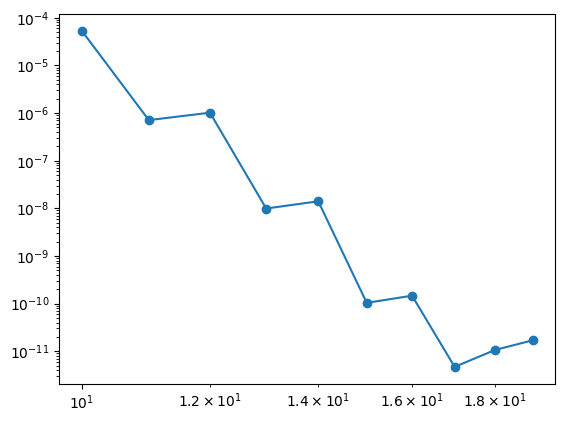

In [9]:
error = []
all_n = range(10,20)
for i in all_n:
    error.append(compute_error_one_d(i))

_ = plt.loglog(all_n, error, 'o-')

As an example, we plot the computed solution with $n=15$ and the real solution to visualize the results.

n = 15 : 1.0368078806324642e-10


1.0368078806324642e-10

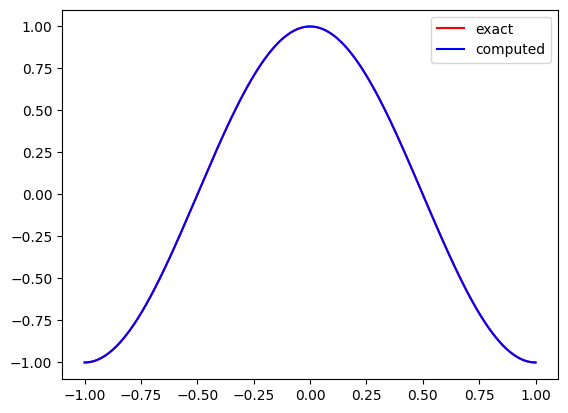

In [10]:
compute_error_one_d(15, plot = True)

The solutions are overlapped one on top of the other since the error between the computed solution and the exact solution is of the order of $10^{-10}$, thus impossible to be seen in a plot.

### 3. Two dimensional matrices

Write a function that, given the number of Chebishev points `n` per each coordinate direction, returns `K`, `M`, and `A` for a two dimensional problem, integrated exactly using Gauss quadrature formulas with the correct number of quadrature points (as matrices, i.e., reshaped to be two dimensional)

In [11]:
def compute_two_dimensional_matrices(n):
  '''compute the two dimensional matrices in the square [-1, 1]^2.
     To do so, make use of the fact that Aij kl = K_ik* M_jl + M_ik*K_jl + M_ik*M_jl.

     Input:
      n: number of Chebyshev pts of type 2 in each direction. (imposed to be the same)
     Output:
      K, M, A
      K: 2-dim stiffness matrix
      M: 2-dim mass matrix
      A: 2-dim FEM matrix (reshaped)

  '''
  #compute one dimensional matrices
  K_1d, M_1d, _ = compute_one_dimensional_matrices(n)

  KM = np.einsum('ik, jl -> ijkl', K_1d, M_1d)
  MK = np.einsum('ik, jl -> ijkl', M_1d, K_1d)
  MM = np.einsum('ik, jl -> ijkl', M_1d, M_1d)
  KK = KM + MK
  AA = KK + MM


  AA = AA.reshape(n**2, n**2)

  return KK, MM, AA


### 3. Error in two dimension

Using 

$
u_{exact}(x) = \cos(\pi x_0)\cos(\pi x_1)
$

as the exact solution, compute the forcing term $f$ that should go on the right hand side of the system to ensure that the exact solution is $u$, i.e., $f = -\Delta u + u$  

Use $f$ to compute the right hand side of your problem, and solve the problem (using `linalg.solve`) for increasing numbers of Chebishev points. Compute the $L^2$ error between the exact solution and the computed approximatio, using a higher order quadrature w.r.t. what you used to assemble the matrices. 

A solution should look like:

![exact_2d.png](https://drive.google.com/uc?id=1CiCRv2TcZ19Tm27OZV_AJnPATW7iQAkW)

The plot was obtained as `imshow(u.reshape((n,n))`.

Plot the error as a function of $n$, for $n$ in $[10,...,20]$.

In [13]:
def rhs_two_d(x):
  n = len(x)
  #Generate quadrature points
  # nq is the size of the quadrature points
  nq = n
  q, w = np.polynomial.legendre.leggauss(nq)
  qqx, qqy = np.meshgrid(q,q)

  f_two_d = f(qqx, qqy)

  B = np.empty((n,nq))
  for i, v_i in enumerate(lagrangian_basis_generator(x)):
    B[i,:] = v_i(q)

  rhs = np.einsum('ab, ia, jb, a, b -> ij', f_two_d, B, B, w, w )
  
  return rhs.reshape(n**2)

In [16]:
def compute_error_two_d(n, plot = False):
  # Generate the matrices. Quadrature rule is of order: 
  *_, A = compute_two_dimensional_matrices(n)

  # Generate the chebyshev points of type 2
  X_cheb = np.polynomial.chebyshev.chebpts2(n)

  rhs = rhs_two_d(X_cheb)

  coeff = np.linalg.solve(A, rhs)
  coeff = coeff.reshape((n,n))

  
  if plot == True:
    #Basis generator
    basis = list(lagrangian_basis_generator(X_cheb))

    m = 256
    x_plot = np.linspace(-1, 1, m, endpoint=True)
    xx, yy = np.meshgrid(x_plot, x_plot)

    u_app = np.zeros((m, m))
    for i, v_i in enumerate(basis):
      for j, v_j in enumerate(basis):
        u_app += coeff[i,j]*v_i(xx)*v_j(yy)

    u_ex = u_exact(xx, yy)

    fig = plt.figure()
    fig.add_subplot(1, 2, 1)
    plt.imshow(u_ex)
    plt.title("Exact")
    fig.add_subplot(1,2,2)
    plt.imshow(u_app)
    plt.title("Computed")
    plt.show()
  
  q, w = np.polynomial.legendre.leggauss(n+1)
  qx,qy = np.meshgrid(q,q)
  wx,wy = np.meshgrid(w,w)
  
  basis = list(lagrangian_basis_generator(X_cheb))
  u_app = np.zeros((n+1, n+1))
  for i, v_i in enumerate(basis):
    for j, v_j in enumerate(basis):
      u_app += coeff[i,j]*v_i(qx)*v_j(qy)
  error = np.sqrt(np.sum((u_exact(qx,qy)-u_app)*(u_exact(qx,qy)-u_app)*wx*wy))
  print('n =', n,':', error)
  return error


Error at each iteration:
n = 10 : 7.352360874519388e-05
n = 11 : 9.601840347191598e-07
n = 12 : 1.4187011375514763e-06
n = 13 : 1.3551270097434622e-08
n = 14 : 1.9674540960052254e-08
n = 15 : 1.4320608550780806e-10
n = 16 : 2.0578518011904804e-10
n = 17 : 2.7453159291776195e-12
n = 18 : 5.429144852407607e-12
n = 19 : 1.0801309338474286e-11


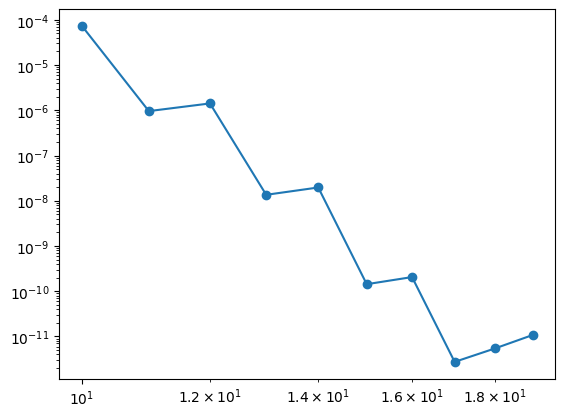

In [17]:
error = []
all_n = range(10,20)
print('Error at each iteration:')
for i in all_n:
    error.append(compute_error_two_d(i))

_ = plt.loglog(all_n, error, 'o-')

We show the results graphically for $n=15$ to check that the solutions match. 

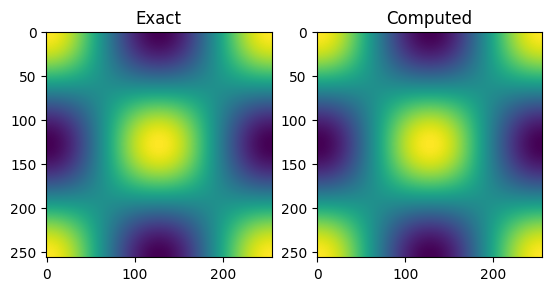

n = 15 : 1.4320608550780806e-10


In [18]:
_ = compute_error_two_d(15, True)

### 4. Conjugate gradient

The conjugate gradient method does not require the knowledge of the matrix, but only of the result of the matrix vector product with the system matrix A. 

Implement a version of the conjugate gradient method that solves the linear system of the two dimensional problem (up to a given tolerance) by only using a function that implements the matrix vector product, i.e., given a `matvec` function, for example defined by  

~~~
def matvec(src):
    return A.dot(src)
~~~

build a conjugate gradient method that only uses the function `matvec` to evaluate `A.dot(src)`. 

In [19]:
def matvec(v):
  return A.dot(v)

In [20]:
def cg(matv, b, x0, tol=1e-20, maxiter=10000):
  '''Implementation of conjugate gradient method without
     preconditioning. The conjugate gradient method does not
     require the knowledge of the matrix A. It only needs the
     result of the matrix-vector product.
     Input:
      matvec: function which implements matrix-vector product
      b: rhs of system to solve in Ax = b
      x0: initial guess
      tol: tolerance of the solution
      maxiter: maximum amount of iterations
     Output:
      x: np.array of the solution of the system Ax = b
  '''

  # Initialization values
  x_tmp = x0
  res_tmp = p_tmp = b-matv(x0)
  iter = 0 

  # Bound for exit condition based
  # on relative residual
  bound = tol*np.linalg.norm(b, 2)

  norm_res = np.linalg.norm(res_tmp,2)

  while norm_res > bound and iter < maxiter:
    z = matv(p_tmp)

    rho_tmp = np.sum(res_tmp*res_tmp)
    alpha = rho_tmp / np.sum(z*res_tmp)

    x = x_tmp + alpha*p_tmp
    r = res_tmp - alpha*z
    
    # update residual norm for exit condidtion
    norm_res = np.linalg.norm(r, 2)

    rho = np.sum(r*r)
    beta = rho/rho_tmp

    p = r + beta*p_tmp

    x_tmp = x
    res_tmp = r
    p_tmp = p
    rho_tmp = rho
    iter+=1

  return x

In [22]:
def compute_error_two_d_cg(n, matv, plot = False):
  if matv == matvec:
    global A
    *_, A = compute_two_dimensional_matrices(n)
  else:
    global K, M
    K, M, _ = compute_one_dimensional_matrices(n) 

  # Generate the chebyshev points of type 2
  X_cheb = np.polynomial.chebyshev.chebpts2(n)

  rhs = rhs_two_d(X_cheb)

  coeff = cg(matv, rhs, np.zeros(n**2))
  coeff = coeff.reshape((n,n))

  if plot == True:
    #Basis generator
    basis = list(lagrangian_basis_generator(X_cheb))

    m = 256
    x_plot = np.linspace(-1, 1, m, endpoint=True)
    xx, yy = np.meshgrid(x_plot, x_plot)

    u_app = np.zeros((m, m))
    for i, v_i in enumerate(basis):
      for j, v_j in enumerate(basis):
        u_app += coeff[i,j]*v_i(xx)*v_j(yy)
    u_ex = u_exact(xx, yy)

    fig = plt.figure()
    fig.add_subplot(1, 2, 1)
    plt.imshow(u_ex)
    plt.title("Exact")
    fig.add_subplot(1,2,2)
    plt.imshow(u_app)
    plt.title("Computed")
    plt.show()
  q, w = np.polynomial.legendre.leggauss(n+1)
  qx,qy = np.meshgrid(q,q)
  wx,wy = np.meshgrid(w,w)
  
  basis = list(lagrangian_basis_generator(X_cheb))
  u_app = np.zeros((n+1, n+1))
  for i, v_i in enumerate(basis):
    for j, v_j in enumerate(basis):
      u_app += coeff[i,j]*v_i(qx)*v_j(qy)
  error = np.sqrt(np.sum((u_exact(qx,qy)-u_app)*(u_exact(qx,qy)-u_app)*wx*wy))
  print('n =', n,':', error)
  return error

Error at each iteration:
n = 10 : 7.35236087452216e-05
n = 11 : 9.601840347320997e-07
n = 12 : 1.4187011373895467e-06
n = 13 : 1.3551270123846428e-08
n = 14 : 1.9674541043667902e-08
n = 15 : 1.4320602159988142e-10
n = 16 : 2.0578533782512252e-10
n = 17 : 2.7445623141206895e-12
n = 18 : 5.428217802109517e-12
n = 19 : 1.0802845636762304e-11


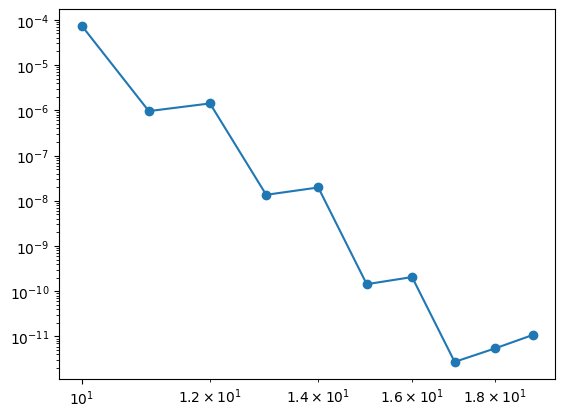

In [23]:
error = []
all_n = range(10,20)
print('Error at each iteration:')
for i in all_n:
    error.append(compute_error_two_d_cg(i, matvec))

_ = plt.loglog(all_n, error, 'o-')

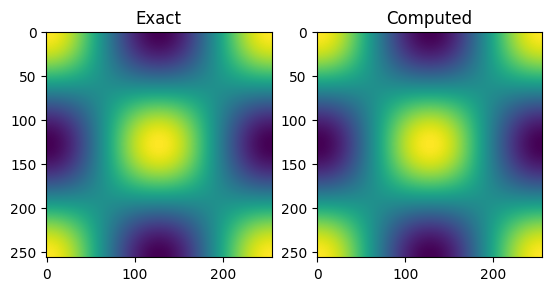

n = 15 : 1.4320602159988142e-10


In [24]:
_ = compute_error_two_d_cg(15, matvec, plot = True)

### 5. "Matrix free" evaluation

Instead of assembling the two (or three dimensional) matrix, and then compute the matrix vector product using `A.dot(v)`, we can exploit the tensor product structure of the problem, and gain some computational time.

In particular, we exploit the fact that the two dimensional matrix is a `reshape` of the array

$
A_{ij,kl} := K_{ik}M_{jl} + M_{ik}K_{jl} + M_{ik}M_{jl}
$

which is constructed using the one dimensional matrices assembled at step 1.

Given an array `v`, it can be reshaped to a matrix of coefficients $v_{ij}$ in $R^{n\times n}$, and we can compute `A.dot(v)` as the sum $w_{ij} = \sum_{kl} A_{ij,kl} v_{kl}$

So `A.dot(v)` reduces to  series of one dimensional matrix-matrix and matrix vector products:


$
w_{ij}  = \sum_{kl} A_{ij,kl} v_{kl} = \sum_{kl} (K_{ik}M_{jl}v_{kl} + M_{ik}K_{jl}v_{kl} + M_{ik}M_{jl}v_{kl})
$

which can be rearranged as 

~~~
def matvec(vinput):
    v = vinput.reshape((n,n))

    Mv = M.dot(v) # result is n x n 
    Kv = K.dot(v) # result is n x n 

    # KT_Mv = K.dot(Mv)  # K is symmetric
    # MT_Kv = M.dot(Kv)  # M is symmetric
    # MT_Mv = M.dot(Mv)  # M is symmetric

    u = K.dot(Mv)
    u += M.dot(Kv) 
    u += M.dot(Mv)
    return u.reshape((n**2,))
~~~

Make a comparison of the timings between using the full two dimensional matrix `A` to compute the matrix vector product, VS using the compressed version above, as we increase `n` from 50 to 100.

In [16]:
def matvec2(vinput):
    n = len(M)
    v = vinput.reshape((n,n))

    Mv = M.dot(v) # result is n x n 
    Kv = K.dot(v) # result is n x n 

    u = Kv.dot(M)
    u += Mv.dot(K) 
    u += Mv.dot(M)
    return u.reshape((n**2,))

First, to test for coherency and correctness, we solve the problem with $n=15$ using "matvec2" instead of "matvec. We expect the results to be comparable since we are only changing the method of matrix-vector multiplication.

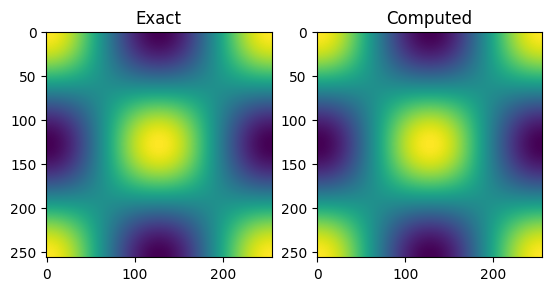

n = 15 : 1.468087433282056e-10


In [17]:
_ = compute_error_two_d_cg(15, matvec2, True)

As we can see, our result is coherent to what we obtained previously. 


Now we compare the timings between both implementations of matrix vector multiplication.

In [20]:
times_using_matrix = []
times_using_tensor = []
print('Size', '\t','Time using full matrix', '\t', 'Time using tensor', '\n')
np.random.seed(123)
for i in range(50, 101):
  K, M, _ = compute_one_dimensional_matrices(i)
  *_, A = compute_two_dimensional_matrices(i)
  v = np.random.rand(i**2)

  t1 = %timeit -n 30 -q -o matvec(v)
  times_using_matrix.append(t1)
  t2 = %timeit -n 30 -q -o matvec2(v)
  times_using_tensor.append(t2)

  print(i, '\t', '%.5f'%t1.best, '\t\t\t', '%.5f'%t2.best, '\n')

Size 	 Time using full matrix 	 Time using tensor 

50 	 0.00184 			 0.00010 

51 	 0.00252 			 0.00010 

52 	 0.00221 			 0.00010 

53 	 0.00261 			 0.00011 

54 	 0.00254 			 0.00011 

55 	 0.00239 			 0.00013 

56 	 0.00308 			 0.00012 

57 	 0.00285 			 0.00013 

58 	 0.00329 			 0.00014 

59 	 0.00335 			 0.00015 

60 	 0.00341 			 0.00014 

61 	 0.00462 			 0.00015 

62 	 0.00501 			 0.00016 

63 	 0.00417 			 0.00019 

64 	 0.00390 			 0.00017 

65 	 0.00417 			 0.00016 

66 	 0.00448 			 0.00022 

67 	 0.00496 			 0.00026 

68 	 0.00564 			 0.00022 

69 	 0.00528 			 0.00016 

70 	 0.00613 			 0.00024 

71 	 0.00602 			 0.00020 

72 	 0.00754 			 0.00027 

73 	 0.00677 			 0.00019 

74 	 0.00705 			 0.00017 

75 	 0.00781 			 0.00021 

76 	 0.00833 			 0.00026 

77 	 0.00910 			 0.00047 

78 	 0.00960 			 0.00024 

79 	 0.01009 			 0.00039 

80 	 0.00998 			 0.00038 

81 	 0.01024 			 0.00037 

82 	 0.01066 			 0.00022 

83 	 0.01084 			 0.00032 

84 	 0.01175 			 0.00024 

85 

Looking at the results we can observe that the matrix free evaluation is much faster than the full matrix formulation. Below we show the plot of the ratio between the time of the matrix formulation and the matrix free formulation:

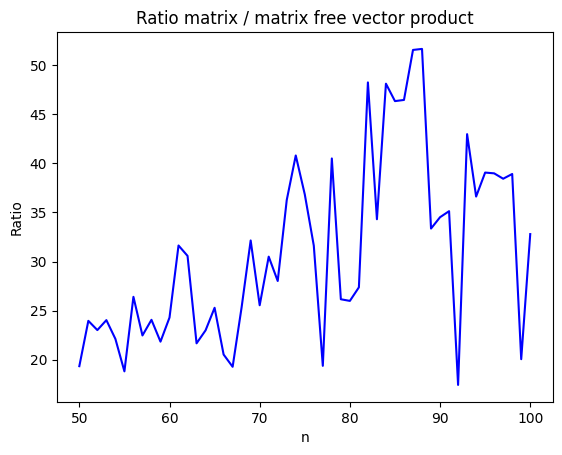

In [21]:
ratio = [times_using_matrix[i].best/times_using_tensor[i].best for i in range(51)]
plt.plot(range(50,101), ratio, color = 'blue')
plt.xlabel('n')
plt.ylabel('Ratio')
plt.title('Ratio matrix / matrix free vector product')
plt.show()

From the plot above we can see that the matrix formulation is around $40$ times slower than the matrix free formulation. In fact, as $n$ gets bigger, the difference becomes even more notable.

### 6. "Matrix free" evaluation for three dimensional problems (mandatory for MHPC, optional for others)

Looking at https://www.geeksforgeeks.org/running-python-script-on-gpu/, implement the same matrix free solver for three dimensional problems, exploiting just in time compilation, numba, and (optionally) GPU acceleration (if you have access to a GPU). 

Compare the timings you get for a fixed number of matrix vector products as n increases from 50 to 100 for the cases 

1. matrix based (assemble the three dimensional A, measure time of 100 A.dot(v)
2. matrix free, pure numpy (using techinque above, measure time 100 applications of matvec(v))
3. matrix free, numba+jit on CPU (measure time 100 applications of matvec(v))
4. (optional) matrix free, numba+jit on GPU (measure time 100 applications of matvec(v))

Comment on your findings.

In [20]:
from numba import jit, cuda

In [33]:
def compute_three_dimensional_matrices(n, K, M):
  #K, M, _ = compute_one_dimensional_matrices(n)

  u = np.einsum('il, jm, kn -> ijklmn', K, M, M)
  u += np.einsum('il, jm, kn -> ijklmn', M, K, M)
  u += np.einsum('il, jm, kn -> ijklmn', M, M, K)
  u += np.einsum('il, jm, kn -> ijklmn', M, M, M)
  
  return u.reshape((n**3, n**3))


In [34]:
def matvec3d(v,n, K, M):
  v = v.reshape((n, n, n))

  kv = K.dot(v)
  mv = M.dot(v)

  kvm = kv.dot(M)
  mvm = mv.dot(M)
  mvk = mv.dot(K)

  u = M.dot(kvm)
  u += K.dot(mvm)
  u += M.dot(mvk)
  u += M.dot(mvm)

  return u.reshape(n**3)

In [35]:
@jit
def matvec3d_cpu(v,n, K, M):
  v = v.reshape((n, n, n))

  kv = K.dot(v)
  mv = M.dot(v)

  kvm = kv.dot(M)
  mvm = mv.dot(M)
  mvk = mv.dot(K)

  u = M.dot(kvm)
  u += K.dot(mvm)
  u += M.dot(mvk)
  u += M.dot(mvm)

  return u.reshape(n**3)


In [42]:
@cuda.jit
def matvec3d_gpu(v,n,u, K, M):
  i,j,k = cuda.grid(3)
  if i<n and j<n and k<n:
    for l in range(n):
      for m in range(n):
        for q in range(n):
          u[i,j,k] += (K[i,l]*M[j,m]*M[k,q] + M[i,l]*K[j,m]*M[k,q] + M[i,l]*M[j,m]*K[k,q] + M[i,l]*M[j,m]*M[k,q])*v[l,m,q]


Unfortunately, using the matrix based implementation with n = 50, the session crashes due to insufficient RAM. This is normal considering that to store a matrix $(50\times50\times 50) \cdot (50\times 50 \times 50) \cdot 8$ (Bytes for doubles) requires around 125 GB of RAM while Colab only offers approximately 13 GB of RAM.
A reasonable limit to experiment with can be obtained with n=20 which requires around 0.5 GB of RAM.
Therefore, I will only show the required time for this specific setting and then I will compare the matrix free methods.

We first check the correctness:


In [43]:
np.random.seed(123)
n = 20
threadsperblock = (10,10,10)
blockspergrid_x = np.ceil(n / threadsperblock[0]).astype('int')
blockspergrid_y = np.ceil(n / threadsperblock[1]).astype('int')
blockspergrid_z = np.ceil(n / threadsperblock[2]).astype('int')
blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)
K, M, _ = compute_one_dimensional_matrices(n)
A = compute_three_dimensional_matrices(n, K, M)
v = np.random.rand(n**3)

u1 = matvec(v)
u2 = matvec3d(v,n, K, M)
u3 = matvec3d_cpu(v,n, K, M)
u4 = np.zeros((n,n,n))
matvec3d_gpu[blockspergrid, threadsperblock](v.reshape((n,n,n)), n, u4, K, M)
u4 = u4.reshape(n**3)

print("u1 == u2? ", np.all(np.abs(u1-u2))<1e-15, '\n')
print('u1 == u3? ', np.all(np.abs(u1-u3))<1e-15, '\n')
print('u1 == u4? ', np.all(np.abs(u1-u4))<1e-15, '\n') 
print('u2 == u3? ', np.all(np.abs(u2-u3))<1e-15, '\n')
print('u2 == u4? ', np.all(np.abs(u2-u4))<1e-15, '\n')
print('u3 == u4? ', np.all(np.abs(u3-u4))<1e-15, '\n')

/home/andres/miniconda3/envs/python310/lib/python3.10/site-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 8 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


u1 == u2?  True 

u1 == u3?  True 

u1 == u4?  True 

u2 == u3?  True 

u2 == u4?  True 

u3 == u4?  True 



/home/andres/miniconda3/envs/python310/lib/python3.10/site-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


As we can see, all three versions are coherent with each other up to machine precision. Therefore we can conclude that the implementations are correct. 

Now we measure the times for n = 20. Note however, that in the case of matvec3d_gpu(), an ulterior reshape operation is missing which is performed in the other methods. 

However, as we will see below, this operation is negligible compared to the time scale being considered for the algorithm itself. Thus, it can be ignored.

In [44]:
#Time for reshape operation
print('Time for reshape: \n')
n = 20
u = np.random.rand(n,n,n)
t = %timeit -q -o u.reshape(n**3)
print('n = 20\t',t.worst, 's')
n = 100
u = np.random.rand(n,n,n)
t = %timeit -q -o u.reshape(n**3)
print('n = 100\t',t.worst, 's')

Time for reshape: 

n = 20	 3.436184400015918e-07 s
n = 100	 3.3942532700166337e-07 s


In [47]:
np.random.seed(123)
n = 20
print('Matrix Based', '\t', 'Free Matrix', '\t', 'Matrix Free Numba+jit CPU', '\t', 'Matrix Free Numba+jit GPU', '\n')
threadsperblock = (10,10,10)
blockspergrid_x = np.ceil(n / threadsperblock[0]).astype('int')
blockspergrid_y = np.ceil(n / threadsperblock[1]).astype('int')
blockspergrid_z = np.ceil(n / threadsperblock[2]).astype('int')
blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)
K, M, _ = compute_one_dimensional_matrices(n)
A = compute_three_dimensional_matrices(n, K, M)
v = np.random.rand(n**3)
u = np.zeros((n,n,n))

t1 = %timeit -n 10 -q -o matvec(v)
t2 = %timeit -n 10 -q -o matvec3d(v, n, K, M)
t3 = %timeit -n 10 -q -o matvec3d_cpu(v, n, K, M)
t4 = %timeit -n 10 -q -o matvec3d_gpu[blockspergrid, threadsperblock](v.reshape((n,n,n)), n, u, K, M)


print('%.5f'%t1.best, '\t', '%.5f'%t2.best, '\t', '%.5f'%t3.best, '\t\t\t', '%.5f'%t4.best, '\n')





Matrix Based 	 Free Matrix 	 Matrix Free Numba+jit CPU 	 Matrix Free Numba+jit GPU 

0.01577 	 0.00108 	 0.00110 			 0.02407 



As we can see, the time for the reshape operation is of order $10^{-5}$ while the algorithms are of order $10^{-2}-10^{-3}$. This means we can ignore the reshape operation and treat matvec3d_gpu() as the complete algorithm when we study the performance of each of the implementations. 

In [48]:
times_free_matrix = []
times_free_numba_cpu = []
times_free_numba_gpu = []
threadsperblock = (10,10,10)

print('Size', '\t', 'Free Matrix', '\t', 'Matrix Free Numba+jit CPU', '\t', 'Matrix Free Numba+jit GPU', '\n')
for i in range(50, 101):
  blockspergrid_x = np.ceil(n / threadsperblock[0]).astype('int')
  blockspergrid_y = np.ceil(n / threadsperblock[1]).astype('int')
  blockspergrid_z = np.ceil(n / threadsperblock[2]).astype('int')
  blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)
  K, M, _ = compute_one_dimensional_matrices(i)
  v = np.random.rand(i**3)
  u = np.zeros((i,i,i))

  t1 = %timeit -q -o matvec3d(v, i, K, M)
  times_free_matrix.append(t1)
  t2 = %timeit -q -o matvec3d_cpu(v, i, K, M)
  times_free_numba_cpu.append(t2)
  t3 = %timeit -q -o matvec3d_gpu[blockspergrid, threadsperblock](v.reshape((i,i,i)), i, u, K, M)
  times_free_numba_gpu.append(t3)

  print(i, '\t', '%.5f'%t1.best, '\t', '%.5f'%t2.best, '\t\t\t', '%.5f'%t3.best, '\n')


Size 	 Free Matrix 	 Matrix Free Numba+jit CPU 	 Matrix Free Numba+jit GPU 

50 	 0.02966 	 0.02996 			 0.35203 

51 	 0.03294 	 0.03325 			 0.37928 

52 	 0.03351 	 0.03356 			 0.40801 

53 	 0.03698 	 0.03702 			 0.41006 

54 	 0.04031 	 0.04035 			 0.43569 

55 	 0.04653 	 0.04545 			 0.46397 

56 	 0.05002 	 0.04938 			 0.48731 

57 	 0.05465 	 0.05477 			 0.50822 

58 	 0.05801 	 0.05750 			 0.53779 

59 	 0.06438 	 0.06380 			 0.56354 

60 	 0.06724 	 0.06708 			 0.59622 

61 	 0.07788 	 0.07593 			 0.62954 

62 	 0.08200 	 0.08081 			 0.65473 

63 	 0.09153 	 0.08877 			 0.68623 

64 	 0.11061 	 0.10707 			 0.72062 

65 	 0.10849 	 0.10457 			 0.75952 

66 	 0.12106 	 0.11057 			 0.80553 

67 	 0.13041 	 0.12280 			 0.84164 

68 	 0.13388 	 0.12080 			 0.88638 

69 	 0.15681 	 0.14449 			 0.91465 

70 	 0.15767 	 0.14547 			 0.96326 

71 	 0.19464 	 0.17704 			 1.00613 

72 	 0.17982 	 0.16411 			 1.04735 

73 	 0.24070 	 0.22170 			 1.11218 

74 	 0.26232 	 0.24646 			 1.15428 

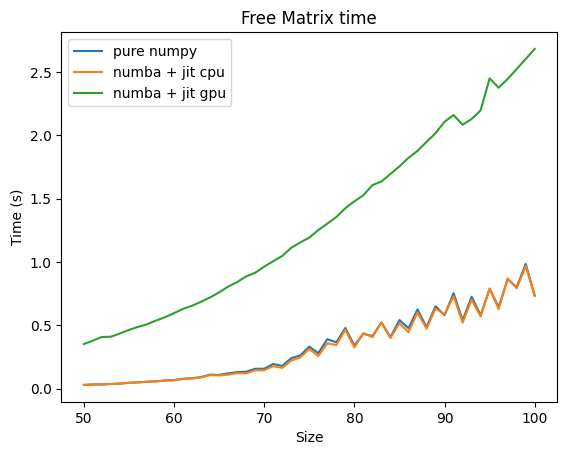

In [49]:
y1 = [times_free_matrix[i].best for i in range(51)]
y2 = [times_free_numba_cpu[i].best for i in range(51)]
y3 = [times_free_numba_gpu[i].best for i in range(51)]
plt.plot(range(50,101), y1, label = 'pure numpy')
plt.plot(range(50,101), y2, label = 'numba + jit cpu')
plt.plot(range(50,101), y3, label = 'numba + jit gpu')
plt.title('Free Matrix time')
plt.xlabel('Size')
plt.ylabel('Time (s)')
plt.legend()
plt.show()

We notice that the gpu implementation is not as efficient as one might hope. This is probably due to an inefficient handling of memory which is something that must be taken care of for gpu programming. Furthermore, there are probably better ways to set the grid dimensions for the threads and blocks.
On the other hand, "numba + jit cpu" seems to be very similar to "pure numpy". This also means that perhaps there are other options that need to be selected in order to truly use numba properly.